**Table of contents**<a id='toc0_'></a>    
- [Hybrid Search with PineCone](#toc1_)    
  - [Set Env](#toc1_1_)    
  - [Create Pinecone Index](#toc1_2_)    
  - [Dense vector (Embedding)](#toc1_3_)    
  - [Sparse Vector](#toc1_4_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc1_'></a>[Hybrid Search with PineCone](#toc0_)

In [ ]:
%pip install --upgrade --quiet  pinecone-client pinecone-text pinecone-notebooks

Note: you may need to restart the kernel to use updated packages.


## <a id='toc1_1_'></a>[Set Env](#toc0_)

In [ ]:
from dotenv import load_dotenv
import os

load_dotenv()

api_key= os.getenv("PINECONE_API_KEY")

## <a id='toc1_2_'></a>[Create Pinecone Index](#toc0_)

In [ ]:
from langchain_community.retrievers import PineconeHybridSearchRetriever
from pinecone import Pinecone,ServerlessSpec

index_name="hybrid-search-langchain-pinecone"

## initialize the Pinecone client
pc=Pinecone(api_key=api_key)

#create the index
if index_name not in pc.list_indexes().names():
    pc.create_index(
        name=index_name,
        dimension=384,  # dimensionality of dense model
        metric="dotproduct",  # sparse values supported only for dotproduct
        spec=ServerlessSpec(cloud="aws", region="us-east-1"),
    )

- This code focuses on creating and configuring an index to perform Hybrid Search using Pinecone and LangChain.

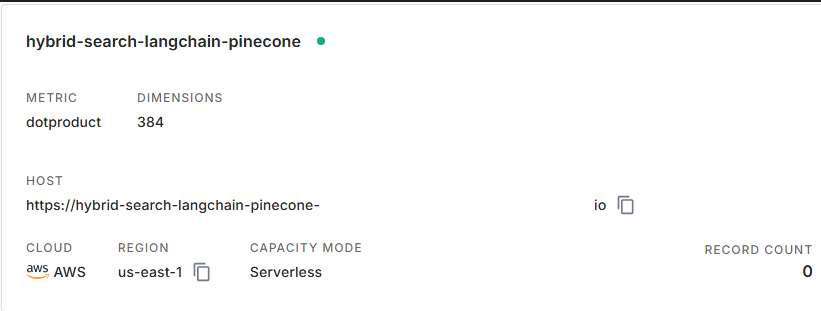

- We have successfully created this index within Pinecone-Database-indexes

In [ ]:
# Create an index object

index=pc.Index(index_name)
index

This line creates an index object with the Pinecone client. This index object provides access to a specific Pinecone index and allows you to perform various operations on it.
For example:
- Retrieving index information
- Deleting an index
- Updating an index
etc...

## <a id='toc1_3_'></a>[Dense vector (Embedding)](#toc0_)

- It is a high-dimensional, dense representation format created by the embedding model. These vectors are used to capture the meaning of texts and typically ensure that semantically similar texts are close to each other in vector space.

- In this context, while the **dense vector** is created by the embedding model (for example, `HuggingFaceEmbeddings`) and represents semantic similarities of texts, the **sparse vector** (for example, BM25) is based more on a linear word-frequency representation.

- **Hybrid search** combines dense and sparse approaches, considering both semantic and word-based matches, thus providing a more effective information retrieval process.

In [ ]:
%pip install tf-keras

In [ ]:
## vector embedding 
import os
from dotenv import load_dotenv
load_dotenv()

os.environ["HF_TOKEN"]=os.getenv("HF_TOKEN")

from langchain_huggingface import HuggingFaceEmbeddings
embeddings=HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")
embeddings

HuggingFaceEmbeddings(model_name='all-MiniLM-L6-v2', cache_folder=None, model_kwargs={}, encode_kwargs={}, multi_process=False, show_progress=False)

## <a id='toc1_4_'></a>[Sparse Vector](#toc0_)

- This code creates an encoder using BM25, a sparse representation method, through Pinecone. BM25 is an information retrieval model for text-based queries and is a popular approach particularly used for comparing documents or texts.

- This encoder can be used in Hybrid Search (Dense + Sparse Search) structures on Pinecone. Sparse vectors can be combined with dense vectors to obtain highly relevant results.

In [8]:
from pinecone_text.sparse import BM25Encoder

# Create BM25 encoder object for sparse text representation
bm25_encoder=BM25Encoder().default()
bm25_encoder

In [9]:
# Sample sentences for BM25 encoding
sentences=[
   "In 2023, I visited Paris",
   "In 2022, I visited New York",
   "In 2021, I visited New Orleans",
]

# Calculate tf-idf values for the sentences and fit the encoder
bm25_encoder.fit(sentences)

# Save the BM25 values to a JSON file for later use
bm25_encoder.dump("bm25_values.json")

# Load previously saved BM25 values back into a new encoder object
bm25_encoder = BM25Encoder().load("bm25_values.json")

  0%|          | 0/3 [00:00<?, ?it/s]

- Create a hybrid search retriever combining dense embeddings and sparse BM25 encoding
- This combines both semantic (dense) and keyword-based (sparse) search capabilities

In [10]:
retriever=PineconeHybridSearchRetriever(embeddings=embeddings,
                                        sparse_encoder=bm25_encoder,
                                        index=index)


retriever

PineconeHybridSearchRetriever(embeddings=HuggingFaceEmbeddings(model_name='all-MiniLM-L6-v2', cache_folder=None, model_kwargs={}, encode_kwargs={}, multi_process=False, show_progress=False), sparse_encoder=<pinecone_text.sparse.bm25_encoder.BM25Encoder object at 0x0000029092F696D0>, index=<pinecone.data.index.Index object at 0x00000290E37D1520>)

- `retriever` creates a retriever that combines both dense (embeddings) and sparse (BM25) search capabilities on Pinecone to provide a more effective information retrieval process.
- In this context, while the `dense vector` is created by the embedding model (for example, HuggingFaceEmbeddings) and represents **semantic similarities** of texts, the `sparse vector` (for example, BM25) is based more on a **word-based** linear frequency representation.
- Hybrid search combines dense and sparse approaches, considering both semantic and word-based matches, thus providing a more effective information retrieval process.

In [11]:
# Add sample texts to the hybrid retriever for indexing
# This will create both dense and sparse vector representations for each text

retriever.add_texts(
    [
    "In 2023, I visited Paris",
        "In 2022, I visited New York",
        "In 2021, I visited New Orleans",
]
)

  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
result = retriever.invoke("What city did i visit first")
result[0]

Document(metadata={'score': 0.240048274}, page_content='In 2021, I visited New Orleans')

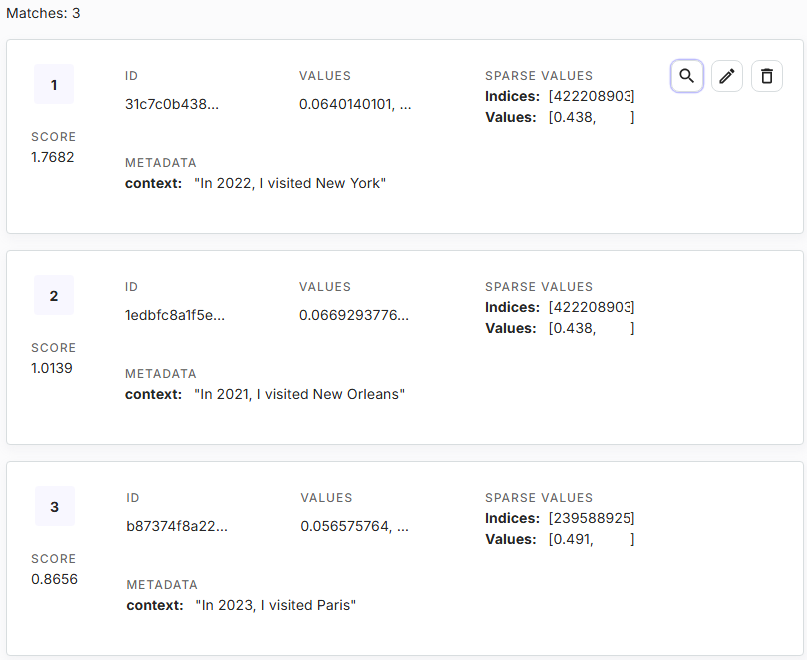

- The hybrid retriever created unique indexes for each sentence in Pinecone-Database

In [ ]:
# END